In [1]:
#Generator and Discriminator are conditioned.

In [17]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Sequential, load_model,Model
from keras.layers import Dense, LeakyReLU, BatchNormalization
from keras.layers import Input, Flatten, Embedding, multiply, Dropout
from keras.optimizers import Adam
from keras import initializers

In [7]:
#Embedding Layer 
# input_dim: Integer. Size of the vocabulary, i.e. maximum integer index + 1.
# output_dim: Integer. Dimension of the dense embedding.
# input_length: Length of input sequences, when it is constant.
model = Sequential()
model.add(Embedding(1000, 64, input_length=10))
# The model will take as input an integer matrix of size (batch,  
 # input_length), and the largest integer (i.e. word index) in the input  
# should be no larger than 999 (vocabulary size).  
# Now model.output_shape is (None, 10, 64), where `None` is the batch  
# dimension.  
input_array = np.random.randint(1000, size=(32, 10))
model.compile('rmsprop', 'mse')
output_array = model.predict(input_array)
print(input_array.shape,output_array.shape)

(32, 10) (32, 10, 64)


In [8]:
# load dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [9]:
X_train.shape,X_test.shape

((60000, 28, 28), (10000, 28, 28))

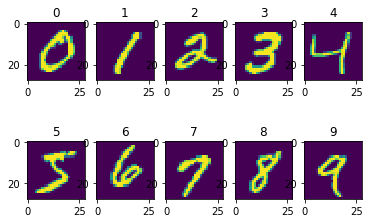

In [10]:
fig = plt.figure()
for i in range(10):
    plt.subplot(2,5,i+1)
    examp = X_train[y_train == i][0]
    plt.imshow(examp)
    plt.title(str(i))

In [11]:
#Reshaping
X_train = X_train.reshape(60000,28*28).astype('float32')
X_train = (X_train / 255 -0.5)*2
X_train.shape

(60000, 784)

In [20]:
#Discriminator
img_dim = 784
discriminator = Sequential()

discriminator.add(Dense(128, input_shape=(img_dim,), kernel_initializer=initializers.RandomNormal(stddev = 0.02)))
discriminator.add(LeakyReLU(alpha=0.2))

discriminator.add(Dense(256))
discriminator.add(LeakyReLU(alpha=0.2))

discriminator.add(Dense(512))
discriminator.add(LeakyReLU(alpha=0.2))

discriminator.add(Dense(1, activation='sigmoid'))
discriminator.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 128)               100480    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               33024     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

In [21]:
#Conditional D
num_classes = 10
label_d = Input(shape=(1,), dtype='int32')
label_embedding_d = Embedding(num_classes, img_dim)(label_d)
label_embedding_d = Flatten()(label_embedding_d)

img_d = Input(shape=(img_dim,))


input_discriminator = multiply([img_d, label_embedding_d])


val = discriminator(input_discriminator)

discriminator = Model([img_d, label_d], val)
discriminator.summary()


Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 1, 784)       7840        input_8[0][0]                    
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 784)          0           embedding_7[0][0]                
_______________________________________________________________________________________

In [22]:
# Optimizer
optimizer = Adam(lr=0.0002, beta_1=0.5)

discriminator.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

In [25]:
# latent space dimension
latent_dim = 100



# Generator network
generator = Sequential()

generator.add(Dense(128, input_shape=(latent_dim,), kernel_initializer=initializers.RandomNormal(stddev = 0.02)))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))

generator.add(Dense(256))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))

generator.add(Dense(512))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))


generator.add(Dense(img_dim, activation='tanh'))
generator.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 128)               12928     
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense_13 (Dense)             (None, 256)               33024     
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_14 (Dense)             (None, 512)              

In [26]:
# Create label embeddings
label = Input(shape=(1,), dtype='int32')
label_embedding = Embedding(num_classes, latent_dim)(label)
label_embedding = Flatten()(label_embedding)

# latent space
z = Input(shape=(latent_dim,))

input_generator = multiply([z, label_embedding])

img = generator(input_generator)

generator = Model([z, label], img)
generator.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 1, 100)       1000        input_10[0][0]                   
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
flatten_4 (Flatten)             (None, 100)          0           embedding_8[0][0]                
_______________________________________________________________________________________

In [27]:
discriminator.trainable = False

validity = discriminator([generator([z, label]), label])

d_g = Model([z, label], validity)

d_g.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])
d_g.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
functional_5 (Functional)       (None, 784)          584312      input_11[0][0]                   
                                                                 input_10[0][0]                   
__________________________________________________________________________________________________
functional_3 (Functional)       (None, 1)            273441      functional_5[0][0]    

W1217 13:20:54.254506 140171682694976 def_function.py:120] 5 out of the last 5 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f7bbc071620> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


epoch = 1/100, d_loss=0.690, g_loss=0.865                                                                                                                      


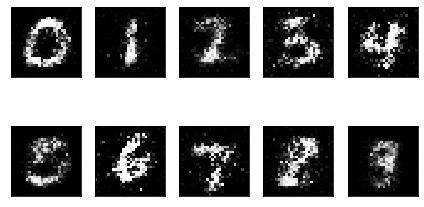

epoch = 2/100, d_loss=0.700, g_loss=0.826                                                                                                                      
epoch = 3/100, d_loss=0.698, g_loss=0.811                                                                                                                      
epoch = 4/100, d_loss=0.684, g_loss=0.826                                                                                                                      
epoch = 5/100, d_loss=0.686, g_loss=0.843                                                                                                                      
epoch = 6/100, d_loss=0.662, g_loss=0.823                                                                                                                      
epoch = 7/100, d_loss=0.685, g_loss=0.837                                                                                                                      
epoch = 8/100, d_loss=0.667, g_loss=0.84

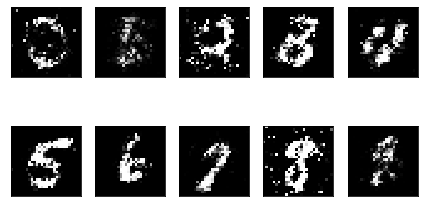

epoch = 12/100, d_loss=0.671, g_loss=0.867                                                                                                                      
epoch = 13/100, d_loss=0.635, g_loss=0.889                                                                                                                      
epoch = 14/100, d_loss=0.651, g_loss=0.952                                                                                                                      
epoch = 15/100, d_loss=0.657, g_loss=0.944                                                                                                                      
epoch = 16/100, d_loss=0.674, g_loss=0.989                                                                                                                      
epoch = 17/100, d_loss=0.659, g_loss=0.918                                                                                                                      
epoch = 18/100, d_loss=0.650, g_lo

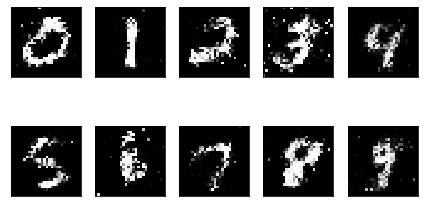

epoch = 22/100, d_loss=0.615, g_loss=0.961                                                                                                                      
epoch = 23/100, d_loss=0.634, g_loss=0.937                                                                                                                      
epoch = 24/100, d_loss=0.672, g_loss=0.932                                                                                                                      
epoch = 25/100, d_loss=0.596, g_loss=0.935                                                                                                                      
epoch = 26/100, d_loss=0.601, g_loss=1.012                                                                                                                      
epoch = 27/100, d_loss=0.657, g_loss=0.977                                                                                                                      
epoch = 28/100, d_loss=0.610, g_lo

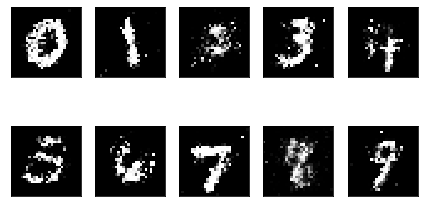

epoch = 32/100, d_loss=0.668, g_loss=0.987                                                                                                                      
epoch = 33/100, d_loss=0.634, g_loss=0.987                                                                                                                      
epoch = 34/100, d_loss=0.686, g_loss=0.886                                                                                                                      
epoch = 35/100, d_loss=0.671, g_loss=0.994                                                                                                                                                                                                                          
epoch = 36/100, d_loss=0.658, g_loss=0.888                                                                                                                      
epoch = 37/100, d_loss=0.659, g_loss=0.881                                                     

Exception ignored in: <bound method IteratorResourceDeleter.__del__ of <tensorflow.python.data.ops.iterator_ops.IteratorResourceDeleter object at 0x7f7b182bdd68>>
Traceback (most recent call last):
  File "/home/paracosma/.virtualenvs/dl4cv/lib/python3.6/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 531, in __del__
    def __del__(self):
KeyboardInterrupt


KeyboardInterrupt: 

In [28]:
epochs = 100
batch_size = 64
smooth = 0.1

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss = []
d_g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):
        
        # Train Discriminator weights
        discriminator.trainable = True
        
        # Real samples
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        real_labels = y_train[i*batch_size:(i+1)*batch_size].reshape(-1, 1)
        
        d_loss_real = discriminator.train_on_batch(x=[X_batch, real_labels], y=real * (1 - smooth))
        
        # Fake Samples
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        random_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)
        X_fake = generator.predict_on_batch([z, random_labels])
        
        d_loss_fake = discriminator.train_on_batch(x=[X_fake, random_labels], y=fake)
         
        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        
        # Train Generator weights
        discriminator.trainable = False
        
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        random_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)
        d_g_loss_batch = d_g.train_on_batch(x=[z, random_labels], y=real)
   
        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, d_g_loss_batch[0]),
            100*' ',
            end='\r'
        )
    
    d_loss.append(d_loss_batch)
    d_g_loss.append(d_g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], d_g_loss[-1]), 100*' ')

    if e % 10 == 0:
        samples = 10
        z = np.random.normal(loc=0, scale=1, size=(samples, latent_dim))
        labels = np.arange(0, 10).reshape(-1, 1)
        
        x_fake = generator.predict([z, labels])

        for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()